<a href="https://colab.research.google.com/github/SMAntony/deep-learning-tools/blob/main/Lab2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

In [ ]:
url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"

dataset = tf.keras.utils.get_file(
    "wiki_crop", url,
    untar=True, cache_dir='.',
    cache_subdir=''
)
dataset_dir = os.path.join(os.path.dirname(dataset), 'wiki_crop')

811327488/811315200 [==============================] - 34s 0us/step


In [ ]:
wikiMat = scipy.io.loadmat("/content/wiki_crop/wiki.mat")

In [ ]:
wikiPlace = wikiMat['wiki'][0][0]
print(len(wikiPlace))
for item in wikiPlace:
  print(item)
  print(len(item[0]))

8
[[723671 703186 711677 ... 720620 723893 713846]]
62328
[[2009 1964 2008 ... 2013 2011 2008]]
62328
[[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31')
  array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31')
  array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29') ...
  array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30')
  array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30')
  array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]]
62328
[[1. 1. 1. ... 1. 1. 0.]]
62328
[[array(['Sami Jauhojärvi'], dtype='<U15')
  array(['Dettmar Cramer'], dtype='<U14')
  array(['Marc Okrand'], dtype='<U11') ...
  array(['Michael Wiesinger'], dtype='<U17')
  array(['Johann Grugger'], dtype='<U14')
  array(['Greta Van Susteren'], dtype='<U18')]]
62328
[[array([[111.29109473, 111.29109473, 252.66993082, 252.66993082]])
  array([[252.4833023 , 126.68165115, 354.53192596, 228.73027481]])
  array([[113.52, 169.84, 366.08, 422.4 ]]) ...
  array([[169.88839786,  74.31669472, 235.2534231 , 1

In [ ]:
wikiMat['wiki'].dtype.names

('dob',
 'photo_taken',
 'full_path',
 'gender',
 'name',
 'face_location',
 'face_score',
 'second_face_score')

In [ ]:
if any(np.isnan(wikiMat['wiki']['gender'][0][0][0])):
  remove_nan = np.where(np.isnan(wikiMat['wiki']['gender'][0][0][0])==False)[0]
gender = wikiMat['wiki']['gender'][0][0][0][remove_nan]

file_path = np.vectorize(lambda x : os.path.join(dataset_dir,x[0]))
file_path = file_path(wikiMat["wiki"]["full_path"][0][0][0][remove_nan])

In [ ]:
file_path

array(['./wiki_crop/17/10000217_1981-05-05_2009.jpg',
       './wiki_crop/48/10000548_1925-04-04_1964.jpg',
       './wiki_crop/12/100012_1948-07-03_2008.jpg', ...,
       './wiki_crop/09/9998109_1972-12-27_2013.jpg',
       './wiki_crop/00/9999400_1981-12-13_2011.jpg',
       './wiki_crop/80/999980_1954-06-11_2008.jpg'], dtype='<U49')

In [ ]:
file_gender_ds = tf.data.Dataset.from_tensor_slices((file_path,gender))

def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string,channels=1)
    image = tf.image.resize(image_decoded, [256, 256])/256
    return image, tf.expand_dims(label,0)

img_gender_ds = file_gender_ds.map(parse_function).shuffle(seed=2,buffer_size=64)

In [ ]:
next(file_gender_ds.as_numpy_iterator())

(b'./wiki_crop/17/10000217_1981-05-05_2009.jpg', 1.0)

In [ ]:
!ls datasets


ls: cannot access 'datasets': No such file or directory


In [ ]:
len(img_gender_ds)

59685

In [ ]:
dataset_size = img_gender_ds.cardinality().numpy()
print(dataset_size)

59685


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = img_gender_ds.take(dataset_size*.6).batch(128).prefetch(AUTOTUNE)
val_ds = img_gender_ds.skip(dataset_size*.6).take(dataset_size*.2).batch(128).prefetch(AUTOTUNE)
test_ds = img_gender_ds.skip(dataset_size*.8).take(dataset_size*.2).batch(128).prefetch(AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(5,5),padding="same",activation="relu",input_shape=(256,256,1)),
    tf.keras.layers.MaxPool2D((4,4),strides = 2),
    tf.keras.layers.Conv2D(32,(5,5),padding = "valid",activation="relu"),
    tf.keras.layers.MaxPool2D((4,4),strides = 4),
    tf.keras.layers.Conv2D(64,(5,5),padding = "valid",activation="relu"),
    tf.keras.layers.MaxPool2D((4,4),strides = 2),
    tf.keras.layers.Conv2D(128,(3,3),padding= "valid",activation="relu",),
    tf.keras.layers.MaxPool2D((2,2),strides = 2),
    tf.keras.layers.Conv2D(256,(1,1),padding= "valid",activation="relu",),
    tf.keras.layers.MaxPool2D((2,2),strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1)                             
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [ ]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
280/280 [==============================] - 95s 287ms/step - loss: 0.5051 - accuracy: 0.7760 - val_loss: 0.4733 - val_accuracy: 0.7974
Epoch 2/10
280/280 [==============================] - 78s 279ms/step - loss: 0.4499 - accuracy: 0.8015 - val_loss: 0.4368 - val_accuracy: 0.8113
Epoch 3/10
280/280 [==============================] - 79s 282ms/step - loss: 0.4055 - accuracy: 0.8245 - val_loss: 0.3735 - val_accuracy: 0.8366
Epoch 4/10
280/280 [==============================] - 78s 280ms/step - loss: 0.3395 - accuracy: 0.8620 - val_loss: 0.3189 - val_accuracy: 0.8772
Epoch 5/10
280/280 [==============================] - 78s 279ms/step - loss: 0.3004 - accuracy: 0.8820 - val_loss: 0.3044 - val_accuracy: 0.8824
Epoch 6/10
280/280 [==============================] - 79s 280ms/step - loss: 0.2789 - accuracy: 0.8910 - val_loss: 0.3060 - val_accuracy: 0.8876
Epoch 7/10
280/280 [==============================] - 78s 279ms/step - loss: 0.2614 - accuracy: 0.8988 - val_loss: 0.3116 - val_ac

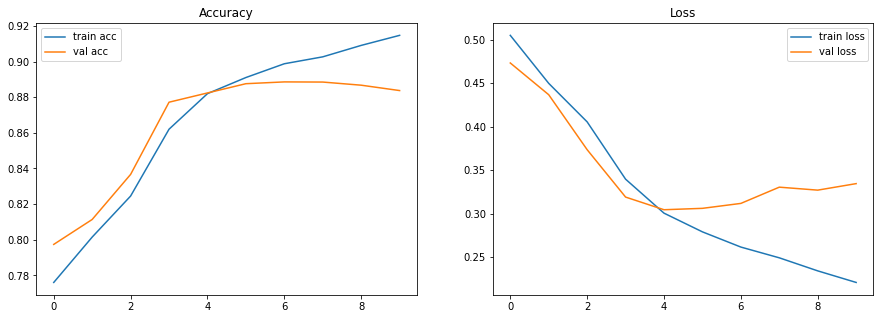

In [ ]:
history = history.history

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

94/94 [==============================] - 35s 100ms/step - loss: 0.3327 - accuracy: 0.8825
Loss:  0.33271944522857666
Accuracy:  0.8824662566184998
